In [34]:
from __future__ import division  # Not needed for Python 3.x
import matplotlib.pyplot as plt
import numpy as np
#from scipy.optimize import fminbound
from scipy import stats
import seaborn as sns
import quantecon as qe
from numba import jit

sns.set_style('whitegrid')
%matplotlib inline

### Using Quant econ DiscreteRV

In [2]:
def mc_sample_path(P, init=0, sample_size=1000):
    # === make sure P is a NumPy array === #
    P = np.asarray(P)
    # === allocate memory === #
    X = np.empty(sample_size, dtype=int)
    X[0] = init
    # === convert each row of P into a distribution === #
    # In particular, P_dist[i] = the distribution corresponding to P[i,:]
    n = len(P)
    P_dist = [qe.DiscreteRV(P[i,:]) for i in range(n)]

    # === generate the sample path === #
    for t in range(sample_size - 1):
        X[t+1] = P_dist[X[t]].draw()

    return X

In [66]:
P = np.array([[0.4, 0.6], 
              [0.2, 0.8]])

X = mc_sample_path(P, sample_size=100000)

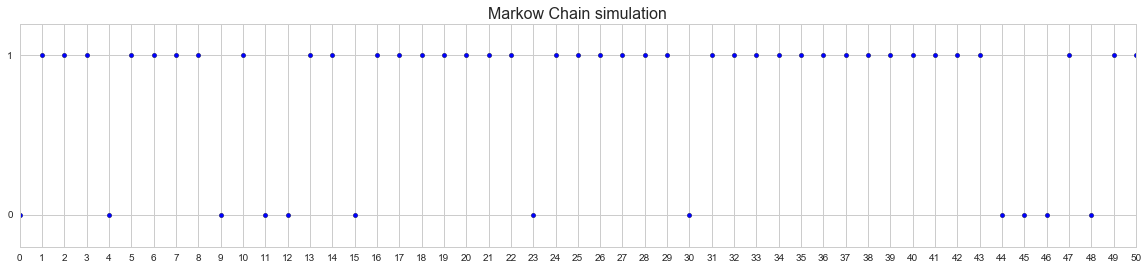

In [19]:
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),X)
plt.xlim(0,50)
plt.xticks(range(0,51))
plt.yticks((0,1))
plt.title("Markow Chain simulation", fontsize=16)
plt.show()

In [20]:
np.mean(X == 0)    # Equivalent to np.sum(X == 0)/len(X)

0.24797

### Numpy version (hand made example)

In [55]:
def mc_sample_path_np(P, init=0, sample_size=1000):
    # === make sure P is a NumPy array === #
    P = np.asarray(P)
    # === allocate memory === #
    X = np.empty(sample_size, dtype=int)
    X[0] = init    
    # === generate the sample path === #
    n = len(P)
    for t in range(sample_size - 1):
        X[t+1] = np.random.binomial(1, P[X[t],1])

    return X

In [65]:
X_np = mc_sample_path_np(P, sample_size=100000)
np.mean(X_np == 0)

0.24907000000000001

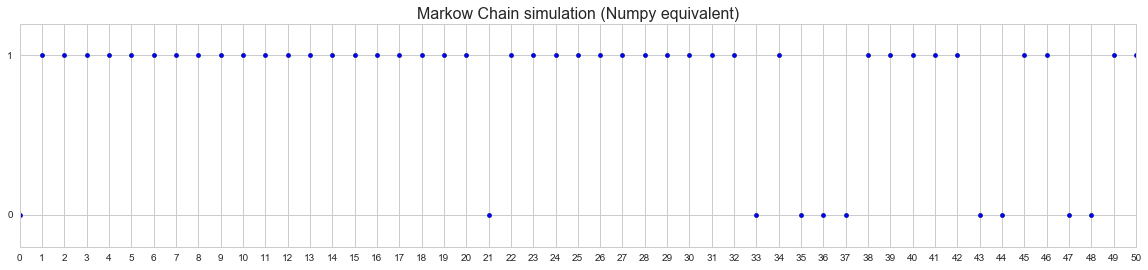

In [57]:
plt.figure(figsize=(20,4))
plt.scatter(range(len(X_np)),X_np)
plt.xlim(0,50)
plt.xticks(range(0,51))
plt.yticks((0,1))
plt.title("Markow Chain simulation (Numpy equivalent)", fontsize=16)
plt.show()

### Quant econ Markov Chain tools

In [64]:
mc = qe.MarkovChain(P)

X_qe = mc.simulate(ts_length=100000)

np.mean(X_qe == 0)

0.24781

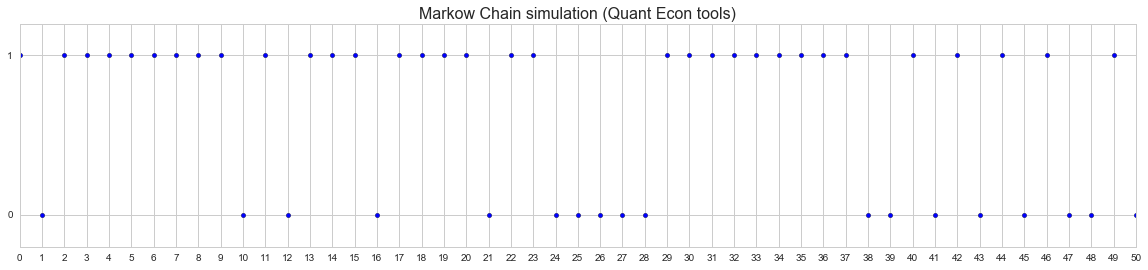

In [61]:
plt.figure(figsize=(20,4))
plt.scatter(range(len(X_qe)),X_qe)
plt.xlim(0,50)
plt.xticks(range(0,51))
plt.yticks((0,1))
plt.title("Markow Chain simulation (Quant Econ tools)", fontsize=16)
plt.show()

In [83]:
lunch = qe.MarkovChain(P, state_values=('Barburrito', 'Nile Valley'))

year_sample = lunch.simulate(ts_length=260, init='Nile Valley')

np.mean(year_sample == 'Nile Valley').round(2)

0.75

### Comparative

In [78]:
%timeit mc_sample_path_np(P, sample_size=1000000) # numpy version

%timeit mc_sample_path(P, sample_size=1000000) # quant econ "hand made" version

%timeit mc.simulate(ts_length=1000000) # qe version

1 loops, best of 3: 1.99 s per loop
1 loops, best of 3: 3.96 s per loop
10 loops, best of 3: 42.3 ms per loop


### Ergodic distributions: convergence

In [84]:
mc.stationary_distributions

array([[ 0.25,  0.75]])

In [131]:
n = 1000
sim = mc_sample_path_np(P, sample_size=n)

distribution_path_1 = np.zeros(n+1)
distribution_path_0 = np.ones(n+1)
for t in range(1,n+1):
    distribution_path_1[t] = np.mean(sim[:t] == 1)
    distribution_path_0[t] = np.mean(sim[:t] == 0)
    # Uncomment below for printing progress
    #if t%100 == 0:
        #print '{}% done'.format(int(t/10))

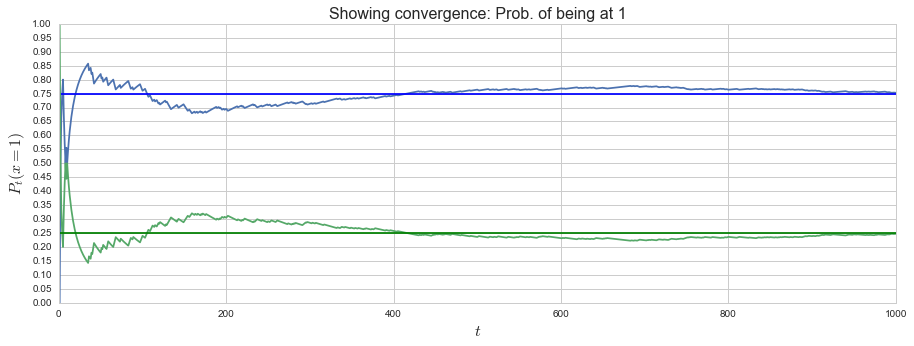

In [133]:
plt.figure(figsize=(15,5))
plt.plot(range(n+1),distribution_path_1)
plt.axhline(mc.stationary_distributions[0,1])
plt.plot(range(n+1),distribution_path_0)
plt.axhline(mc.stationary_distributions[0,0], c='green')
plt.title("Showing convergence: Prob. of being at 1", fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$P_t(x=1)$', fontsize=16)
plt.ylim(0,1)
plt.yticks(np.arange(0,1.05,0.05))
plt.show()

## Exercise: Aspa's choice

Lunch between 3 places, P(eating at y|eating at x today), ergodic distribution, how long until we reach it, 